# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [34]:
import artm

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [37]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [38]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit',target_folder='batches/'
                                       ,batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [39]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
artm_model = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={'text':1, 'author':1},
                      reuse_theta=True, cache_theta=True, num_processors = 2)

In [70]:
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [40]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary(name = 'dictionary')
dictionary.gather(data_path=batch_vectorizer.data_path)
artm_model.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [41]:
# Ваш код
artm_model.scores.add(artm.TopTokensScore(name = 'top_tokens_score_modal1', class_id='text', num_tokens=15))
artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score_modal2', class_id='author', num_tokens=15))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [42]:
# Ваш код
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name ='SmoothPhi', tau=1e5, dictionary='dictionary',
                                                            class_ids='text', topic_names='bcg'), overwrite=True)

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [43]:
# Ваш код
artm_model.num_document_passes = 1
artm_model.fit_offline(batch_vectorizer= batch_vectorizer,num_collection_passes=T)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [62]:
# Ваш код
topic_names_sbj = topic_names
topic_names_sbj.remove('bcg')
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name = 'SparsePhi', tau=-1e5, dictionary='dictionary',
                                                           class_ids='text', topic_names=topic_names_sbj))

AttributeError: Unable to replace existing regularizer.                                  If you really want to do it use overwrite=True argument

Выполните еще 15 проходов по коллекции.

In [45]:
# Ваш код
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=int(T / 2))

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [72]:
# Ваш код
for topic_name in topic_names:
    print(topic_name + ':', end=' ')
    words = artm_model.score_tracker['top_tokens_score_modal1'].last_tokens
    for word in words[topic_name]:
            print(word, end=' ')
    print()

sbj0: церковь власть средневековый император русь святой римский папа князь сага король александр византийский вера рим 
sbj1: планета земля атмосфера солнце солнечный белый газ образовываться карлик вокруг вода поверхность спутник орбита океан 
sbj2: система трудность поведение частота двигаться точность искусственный движение относительность тест час самка задание переход часы 
sbj3: культура понятие культурный восприятие сознание феномен личность воспринимать ощущение чувство повседневный переживание детство этика индивид 
sbj4: право литература искусство литературный юрист писатель должник собственность обязательство владение римский произведение исполнение юридический требование 
sbj5: материал структура молекула свойство углерод применение поверхность полимер кристалл металл электронный твердый трехмерный алмаз углеродный 
sbj6: книга фильм автор кино написать документ жанр театр тема кинематограф академия герой анекдот екатерина культовый 
sbj7: смерть ритуал террор правитель го

In [73]:
tokens_modal_2 = artm_model.score_tracker['top_tokens_score_modal2'].last_tokens
for topic_name in topic_names:
    print(topic_name + ':', end=' ')
    for token in tokens_modal_2[topic_name]:
        print(token, end=' ')
    print()

sbj0: Александр_Марей Фёдор_Успенский Татьяна_Бобровникова Павел_Уваров Алексей_Юдин Игорь_Данилевский Ольга_Вайнштейн Елена_Уханова Ольга_Брилева Владимир_Петрухин Елена_Браун Григорий_Бондаренко Раиса_Кирсанова Екатерина_Болтунова Ольга_Тогоева 
sbj1: Сергей_Попов Кирилл_Еськов Дмитрий_Вибе Дмитрий_Титов Валерий_Сулейманов Зоригто_Намсараев Сергей_Наугольных Александр_Марков Роман_Рафиков Александр_Слободкин Елизавета_Ривкина Наталья_Новикова Сергей_Писарев Дмитрий_Лось Юлия_Краус 
sbj2: Елена_Брызгалина Александр_Поддьяков Владимир_Мележик Михаил_Пантелеев Эмиль_Ахмедов Виталий_Пальчиков Михаил_Фейгельман Даниэль_Сельва Антон_Суворов Василий_Климов Алексей_Желтиков Юджин_Ползик Илья_Щуров Владимир_Редько Алексей_Котов 
sbj3: Пётр_Турчин Алексей_Руткевич Сергей_Арутюнов Владимир_Миронов Татьяна_Смоктунович Андрей_Лосев Константин_Анохин Кирилл_Разлогов Павел_Степанцов Александр_Кислов Фёдор_Гиренок Павел_Умрюхин Дмитрий_Иванов Светлана_Кузнецова Андрей_Лукашов 
sbj4: Дмитрий_Дождев О

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [74]:
sbj_topic_labels = ['Религия', 'Формирование планет', 'Система', 'Этика', 'Римское право',
                   'Кристаллическая структура', 'Кинематограф', 'Террор', 'Химия',
                   'Физика элементарных частиц', 'История', 'Человек', 'Онкология',
                   'Древний Восток', 'Астрономия', 'Психология', 'Раса', 'Философия',
                   'Русский язык', 'Франция', 'Урбан', 'Медицина', 'Социология',
                    'Интеллект', 'Древность', 'Лингвистика', 'Экономика', 'Генетика',
                    'Сверхпроводимость']   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [79]:
artm_model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = artm_model.get_theta()
phi_a = artm_model.get_phi(class_ids='author')

In [80]:
print(theta.shape)
print(phi_a.shape)

(30, 1728)
(539, 30)


In [76]:
theta

,http://postnauka.ru/video/17414,http://postnauka.ru/video/17415,http://postnauka.ru/video/17416,http://postnauka.ru/video/17420,http://postnauka.ru/video/17421,http://postnauka.ru/video/17486,http://postnauka.ru/video/17487,http://postnauka.ru/video/17488,http://postnauka.ru/video/17489,http://postnauka.ru/video/17490,...,http://postnauka.ru/video/12739,http://postnauka.ru/video/12740,http://postnauka.ru/video/12898,http://postnauka.ru/video/12904,http://postnauka.ru/video/12971,http://postnauka.ru/video/12974,http://postnauka.ru/video/13041,http://postnauka.ru/video/13042,http://postnauka.ru/video/13043,http://postnauka.ru/video/13092
sbj0,2.298866e-01,4.315095e-15,0.000000e+00,2.377101e-10,3.150125e-12,7.719977e-12,0.000000e+00,0.000000e+00,0.000000e+00,2.734841e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.234117e-03,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.309296e-11
sbj1,2.893092e-03,0.000000e+00,1.572410e-12,2.820373e-13,0.000000e+00,0.000000e+00,5.781907e-02,0.000000e+00,5.141303e-02,1.471350e-11,...,0.000000e+00,0.000000e+00,9.195036e-03,1.344527e-01,1.015974e-01,0.006743,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sbj2,3.935258e-03,6.977150e-03,1.104701e-02,1.142530e-03,3.974666e-03,0.000000e+00,0.000000e+00,0.000000e+00,9.300073e-07,1.749336e-02,...,2.451666e-03,0.000000e+00,3.764215e-16,0.000000e+00,0.000000e+00,0.000000,1.810136e-02,0.000000e+00,0.000000e+00,2.031627e-02
sbj3,3.650056e-03,3.552374e-02,1.190322e-02,1.177766e-02,4.313950e-02,6.264114e-02,2.149327e-02,0.000000e+00,5.417229e-02,1.622201e-02,...,1.311735e-03,2.711137e-01,3.217801e-02,0.000000e+00,0.000000e+00,0.000000,2.745806e-02,1.281798e-01,0.000000e+00,4.424633e-03
sbj4,2.414785e-07,8.249152e-04,1.114444e-09,6.535791e-03,1.705626e-06,1.138841e-06,4.623027e-04,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.743420e-01,2.545197e-02,0.000000e+00
sbj5,2.113381e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.469663e-10,0.000000e+00,0.000000e+00,4.098542e-11,0.000000e+00,...,1.060684e-10,0.000000e+00,0.000000e+00,3.448274e-02,9.530591e-10,0.170264,0.000000e+00,0.000000e+00,0.000000e+00,8.976783e-09
sbj6,2.297826e-02,0.000000e+00,0.000000e+00,0.000000e+00,3.026576e-03,2.263577e-10,2.773723e-04,0.000000e+00,0.000000e+00,7.023463e-03,...,1.289307e-03,2.757308e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.724012e-02,0.000000e+00,0.000000e+00
sbj7,1.273656e-11,0.000000e+00,0.000000e+00,1.301814e-01,0.000000e+00,3.337453e-05,2.430315e-02,0.000000e+00,1.142858e-02,1.648127e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sbj8,1.014679e-04,1.819741e-08,5.098704e-03,6.517499e-03,1.134308e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.098654e-01,2.532412e-01,0.102147,1.001527e-03,1.203015e-02,0.000000e+00,1.070302e-01
sbj9,0.000000e+00,0.000000e+00,3.089531e-04,8.413803e-03,2.974696e-06,5.757591e-03,7.504681e-03,2.743792e-02,8.476093e-03,3.501244e-02,...,0.000000e+00,0.000000e+00,6.436883e-04,4.447733e-11,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.443009e-01,1.382242e-03


In [77]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
"(author, Ярослав_Исполатов)",0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,3.775206e-15,0.0,0.0,0.000000e+00,0.0,1.097457e-13,0.0,0.0,0.004767
"(author, Сергей_Демокритов)",0.0,0.0,4.947833e-16,0.000000,0.0,0.0,0.0,0.0,0.000000,0.034883,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000
"(author, Руслан_Смелянский)",0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.005893,0.000000,...,0.076629,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000
"(author, Александр_Апт)",0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.042611,0.000000,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000
"(author, Людмила_Новикова)",0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000e+00,0.0,0.0,1.466991e-07,0.0,0.000000e+00,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(author, Дарья_Радченко)",0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.029642,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000
"(author, Ирина_Каспэ)",0.0,0.0,0.000000e+00,0.020590,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000
"(author, Марина_Корсакова-Крейн)",0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.023255,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000
"(author, Павел_Степанцов)",0.0,0.0,0.000000e+00,0.041181,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

<AxesSubplot:>

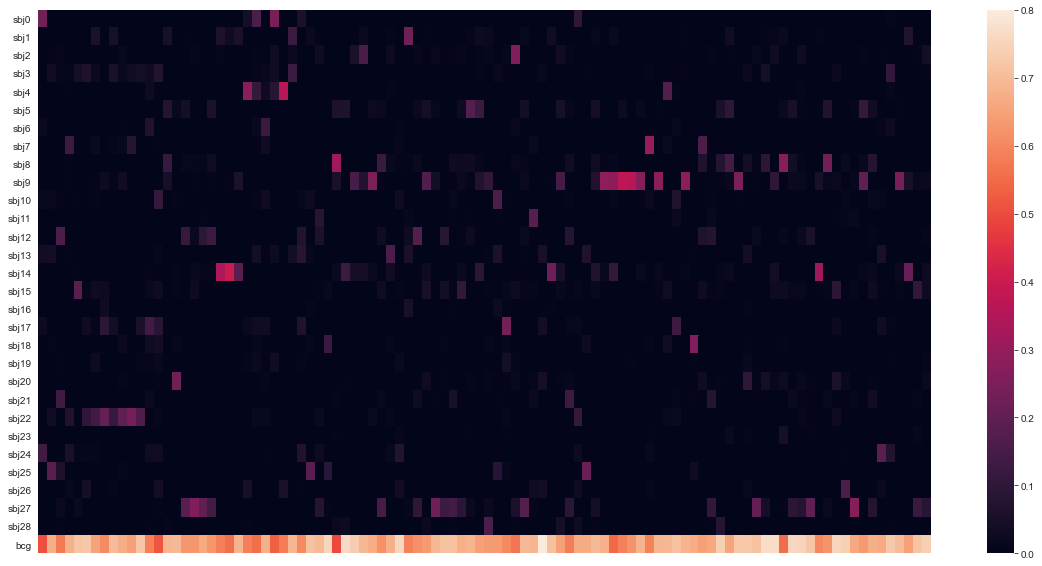

In [96]:
# Ваш код
plt.figure(figsize=((20,10)))
seaborn.heatmap(theta.iloc[:,:100], xticklabels=False)

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [104]:
print([theta.iloc[i] for i in range(theta.shape[0])])

[http://postnauka.ru/video/17414    2.298866e-01
http://postnauka.ru/video/17415    4.315095e-15
http://postnauka.ru/video/17416    0.000000e+00
http://postnauka.ru/video/17420    2.377101e-10
http://postnauka.ru/video/17421    3.150125e-12
                                       ...     
http://postnauka.ru/video/12974    0.000000e+00
http://postnauka.ru/video/13041    0.000000e+00
http://postnauka.ru/video/13042    0.000000e+00
http://postnauka.ru/video/13043    0.000000e+00
http://postnauka.ru/video/13092    5.309296e-11
Name: sbj0, Length: 1728, dtype: float32, http://postnauka.ru/video/17414    2.893092e-03
http://postnauka.ru/video/17415    0.000000e+00
http://postnauka.ru/video/17416    1.572410e-12
http://postnauka.ru/video/17420    2.820373e-13
http://postnauka.ru/video/17421    0.000000e+00
                                       ...     
http://postnauka.ru/video/12974    6.742887e-03
http://postnauka.ru/video/13041    0.000000e+00
http://postnauka.ru/video/13042    0.000000e+

In [112]:
# Ваш код
# Просуммируем по документам конкретную тему
value = [np.sum(theta.iloc[i]) for i in range(theta.shape[0])]
# Поделим на сумму
probability_theme_norm = value / np.sum(value)

In [116]:
df = pd.DataFrame(data = probability_theme_norm, index = topic_labels, columns=['Probability'])

In [117]:
df

,Probability
Религия,0.011971
Формирование планет,0.012341
Система,0.009094
Этика,0.014260
Римское право,0.008992
Кристаллическая структура,0.010729
Кинематограф,0.007117
Террор,0.004947
Химия,0.014191
Физика элементарных частиц,0.022604


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [119]:
df.sort_values(by = 'Probability')

,Probability
Раса,0.004552
Террор,0.004947
Сверхпроводимость,0.006301
Франция,0.006674
Человек,0.007033
Кинематограф,0.007117
Интеллект,0.007213
Онкология,0.008045
Римское право,0.008992
Урбан,0.009073


In [125]:
print(df.sort_values(by = 'Probability', ascending=False)[:7])

                            Probability
Фоновая тема                   0.658871
Генетика                       0.025206
Физика элементарных частиц     0.022604
Астрономия                     0.019979
Философия                      0.016930
История                        0.016311
Древность                      0.015863


In [127]:
print(df.sort_values(by = 'Probability')[:3])

                   Probability
Раса                  0.004552
Террор                0.004947
Сверхпроводимость     0.006301


Ваш ответ:
5 тем с max p(t): __Физика элементарных частиц, Астрономия, Философия, История, Древность__ (Генетика тоже, однако, почему-то ее посчитали общенаучной, хотя этого не особо заметно)
3 темы с min p(t): __Раса, Террор, Сверхпроводимость__

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

In [130]:
print(phi_a.shape)

(539, 30)


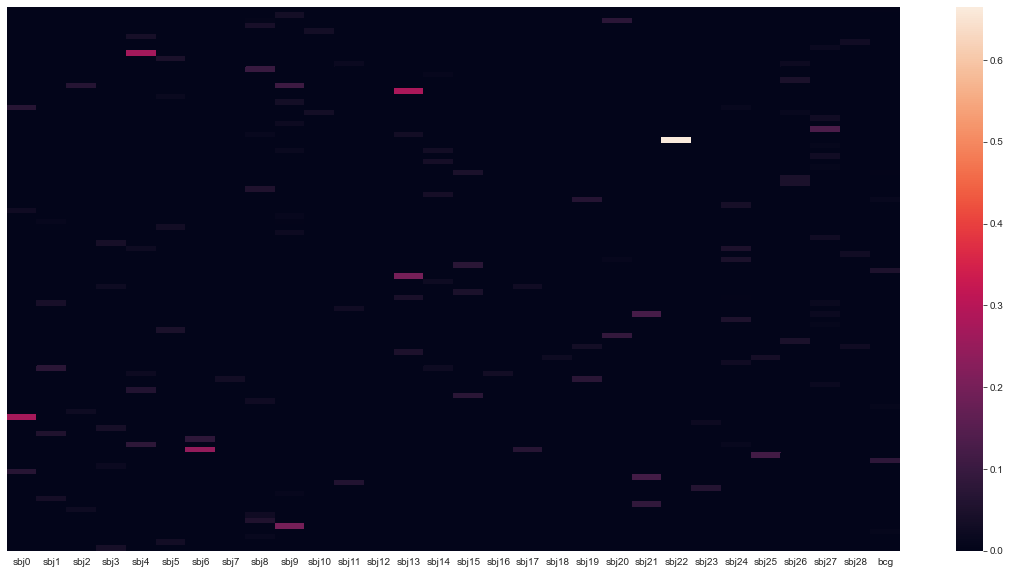

In [132]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(data = phi_a.iloc[:100], yticklabels=False)
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [175]:
pd.options.display.max_columns= 30
pd.options.display.max_rows= 999

In [218]:
# Функция принимает на вход матрицу phi, отдается кортеж списков - Авторы и соответствующие темы
def count_themes_for_authors(phi):
    list_of_authors = []
    list_of_themes_for_authors = []
    list_tmp = []
    for row in phi.iterrows():
        list_of_authors.append(row[0][1])
        for index_ ,prob in enumerate(row[1]):
            if(prob > 0.01):
                list_tmp.append(topic_labels[index_])
        list_of_themes_for_authors.append(list_tmp)
        list_tmp = []
    return list_of_authors, list_of_themes_for_authors

In [219]:
authors, themes = count_themes_for_authors(phi_a)

In [238]:
for index, l in enumerate(themes):
    if (len(l) >= 3):
        print(l, authors[index], sep = '\t')

['Система', 'Террор', 'Медицина']	Елена_Брызгалина
['Система', 'Химия', 'Онкология']	Андрей_Цатурян
['Римское право', 'Террор', 'Русский язык']	Алина_Бодрова
['Формирование планет', 'Химия', 'Сверхпроводимость']	Дмитрий_Лось


Ваш ответ:
авторы, значимые в не менее чем 3 темах: __Елена Брызгалина, Андрей Цатурян, Алина Бодрова, Дмитрий Лось__

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [239]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [260]:
print(df.iloc[1])

Probability    0.012341
Name: Формирование планет, dtype: float32


In [263]:
print(df.values.shape)

(30, 1)


In [265]:
test = df.values.reshape((30,))

In [266]:
print(test.shape)

(30,)


In [271]:
# Ваш код
author_theme_profile = np.zeros(phi_a.shape)
for i in range(phi_a.shape[0]):
    for j in range(phi_a.shape[1]):
        author_theme_profile[i,j] = phi_a.iloc[i,j] * df.iloc[j] / np.sum( df['Probability'].values * phi_a.iloc[i,:] ) 

In [272]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=22)
cosine = pairwise_distances(author_theme_profile,metric='cosine')
res = mds.fit_transform(cosine)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [274]:
print(res)

[[ 0.49576387  0.4605593 ]
 [ 0.15820998 -0.69808416]
 [ 0.63046803 -0.38422963]
 ...
 [ 0.15820998 -0.69808416]
 [ 0.17666831 -0.22545216]
 [ 0.15820998 -0.69808416]]


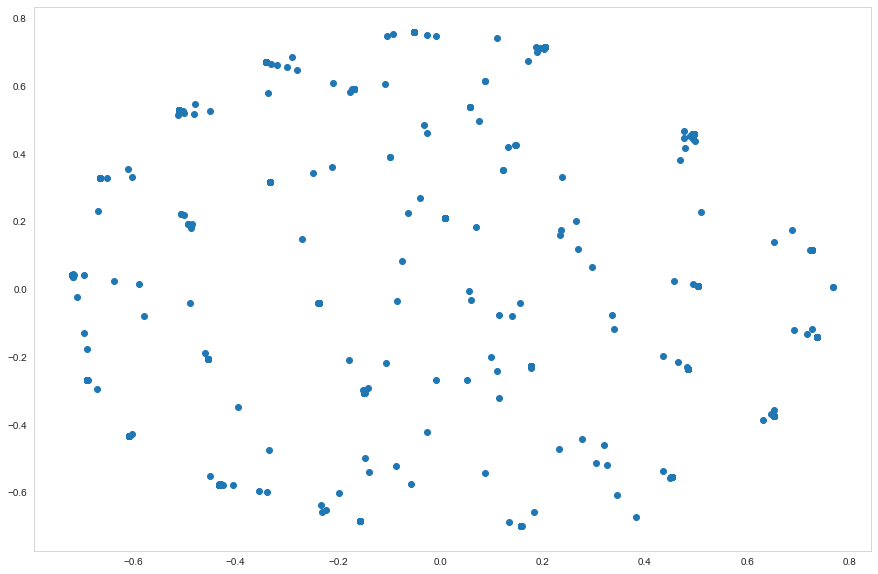

In [278]:
# Ваш код
plt.figure(figsize=(15,10))
plt.scatter(res[:,0], res[:,1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код


##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [ ]:
# Ваш код


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [ ]:
print "http://yandex.ru"   # получится кликабельная ссылка

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [1]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [ ]:
# Ваш код


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 